# GraphRAG Python package End-to-End Example

This notebook contains an end-to-end worked example using the [GraphRAG Python package](https://neo4j.com/docs/neo4j-graphrag-python/current/index.html) for Neo4j. It starts with unstructured documents (in this case pdfs), and progresses through knowledge graph construction, knowledge graph retriever design, and complete GraphRAG pipelines. 

Research papers on Lupus are used as the data source. We design a couple of different retrievers based on different knowledge graph retrieval patterns. 

For more details and explanations around each of the below steps, see the [corresponding blog post](https://neo4j.com/blog/graphrag-python-package/) which contains a full write-up, in-depth comparison of the retrieval patterns, and additional learning resources. 

## Pre-Requisites

1. __Create a Neo4j Database__: To work through this RAG example, you need a database for storing and retrieving data. There are many options for this. You can quickly start a free Neo4j Graph Database using [Neo4j AuraDB](https://neo4j.com/product/auradb/?ref=neo4j-home-hero). You can use __AuraDB Free__ or start an __AuraDB Professional (Pro) free trial__ for higher ingestion and retrieval performance. The Pro instances have a bit more RAM; we recommend them for the best user experience.
2. __Obtain an OpenAI Key__: This example requires an OpenAI API key to use language models and embedders. The cost should be very minimal. If you do not yet have an OpenAI API key you can [create an OpenAI account](https://platform.openai.com/signup) or [sign in](https://platform.openai.com/login). Next, navigate to the [API key page](https://platform.openai.com/account/api-keys) and click "Create new secret key". Optionally naming the key. 
3. __Fill in Credentials__: Either by copying the [`.env.template`](.env.template) file, naming it `.env`, and filling in the appropriate credentials, or by manually putting the credentials into the second code cell below. You will need:
    1. The Neo4j URI, username, and password variables from when you created the database. If you created your database on AuraDB, they are in the file you downloaded.
    2. Your OpenAI API key.


Other useful sources:
- Repo from this notebook: https://github.com/neo4j-product-examples/graphrag-python-examples/tree/main
- Full guide for GraphRAG in Python: https://neo4j.com/docs/neo4j-graphrag-python/current/index.html
- Another implementation of GraphRAG with Neo4j: https://github.com/neo4j-product-examples/genai-workshop/tree/main/talent

## Setup

In [ ]:
# %%capture
# %pip install fsspec langchain-text-splitters tiktoken python-dotenv numpy torch neo4j-graphrag google-genai langchain-google-genai "neo4j-graphrag[sentence-transformers]" polars

### Libraries and credentials

In [1]:
from dotenv import load_dotenv
import os
from google import genai

# load neo4j credentials (and openai api key in background).
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

### Gemini API

In [2]:
if GEMINI_API_KEY:
    client = genai.Client(api_key=GEMINI_API_KEY)  # Configure the API key for genai

# Display available models
for model in client.models.list():
    print(model)

name='models/embedding-gecko-001' display_name='Embedding Gecko' description='Obtain a distributed representation of a text.' version='001' endpoints=None labels=None tuned_model_info=TunedModelInfo(base_model=None, create_time=None, update_time=None) input_token_limit=1024 output_token_limit=1 supported_actions=['embedText', 'countTextTokens']
name='models/gemini-1.0-pro-vision-latest' display_name='Gemini 1.0 Pro Vision' description='The original Gemini 1.0 Pro Vision model version which was optimized for image understanding. Gemini 1.0 Pro Vision was deprecated on July 12, 2024. Move to a newer Gemini version.' version='001' endpoints=None labels=None tuned_model_info=TunedModelInfo(base_model=None, create_time=None, update_time=None) input_token_limit=12288 output_token_limit=4096 supported_actions=['generateContent', 'countTokens']
name='models/gemini-pro-vision' display_name='Gemini 1.0 Pro Vision' description='The original Gemini 1.0 Pro Vision model version which was optimized 

### Data

In [3]:
import polars as pl

df = pl.read_parquet('FILTERED_DATAFRAME.parquet')

display(df.head(5))
print(f'Number of rows: {df.shape[0]}')

state,date,month_year,year,event_code,quad_class,goldstein_scale,avg_tone,actor1_statecode,actor2_statecode,url,title,full_text
str,i64,i64,i64,i64,i64,f64,f64,str,str,str,str,str
"""USMO""",20210514,202105,2021,16,1,-2.0,-8.934073,"""USMO""","""USMO""","""https://www.natlawreview.com/a…","""State of the Law for Business …","""It’s been a year since COVID-1…"
"""USMO""",20210514,202105,2021,141,3,-6.5,-0.808625,"""USMO""","""USMO""","""https://www.kcur.org/health/20…","""Medicaid Expansion Supporters …","""A day after Missouri Gov. Mike…"
"""USMO""",20210529,202105,2021,13,1,0.4,-6.008584,"""USMO""","""USMO""","""https://www.dailystar.co.uk/ne…","""Elderly woman sucker-punched t…","""Elderly woman sucker-punched t…"
"""USAR""",20200207,202002,2020,16,1,-2.0,-8.0,"""USAR""",null,"""https://www.houstonchronicle.c…",null,null
"""USNH""",20201206,202012,2020,70,2,7.0,0.088106,"""USNH""","""USNH""","""https://www.fosters.com/story/…","""Historically Speaking: Adventu…","""Historically Speaking: Adventu…"


Number of rows: 139828


In [4]:
# Create a subset of the dataframe

n = 100  # Number of rows to sample

df_subset = df.head(n)

print(f'Number of rows in subset: {df_subset.shape[0]}')

Number of rows in subset: 100


## Knowledge Graph Building

The `SimpleKGPipeline` class allows you to automatically build a knowledge graph with a few key inputs, including
- a driver to connect to Neo4j,
- an LLM for entity extraction, and
- an embedding model to create vectors on text chunks for similarity search.

There are also some optional inputs, such as node labels, relationship types, and a custom prompt template, which we will use to improve the quality of the knowledge graph. For full details on this, see [the blog](https://neo4j.com/blog/graphrag-python-package/).

More information on the usage of other LLMs (different from OpenAI's): https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_rag.html#using-another-llm-model

In [5]:
import neo4j

# Create the Neo4j driver
driver = neo4j.GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

### Creating LLM instance

To work with Google Gemini, there are 2 possibilities:
- Either work through `langchain` (see https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_rag.html#using-a-model-from-langchain and https://python.langchain.com/v0.2/docs/integrations/llms/google_ai/)
- Or create a custom model class for Neo4j (https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_rag.html#using-a-custom-model)

And within LangChain, there are again 2 possibilities:
*   **`langchain_google_genai.llms.GoogleGenerativeAI`** (https://python.langchain.com/api_reference/google_genai/llms/langchain_google_genai.llms.GoogleGenerativeAI.html#langchain_google_genai.llms.GoogleGenerativeAI): This class is designed to work with Language Models (LLMs) in a text-in, text-out fashion. You provide a text prompt, and it returns a text completion. It's a direct interface to the LLM, suitable for tasks like text generation, translation, and summarization where you primarily need the model to complete a given input.

*   **`langchain_google_genai.chat_models.ChatGoogleGenerativeAI`** (https://python.langchain.com/api_reference/google_genai/chat_models/langchain_google_genai.chat_models.ChatGoogleGenerativeAI.html#langchain_google_genai.chat_models.ChatGoogleGenerativeAI): This class is designed for conversational models. It expects input in the form of "messages" with roles (e.g., "system", "user", "assistant"). It maintains a conversation history and structures the input to the model in a way that's conducive to multi-turn dialogues. The output is also structured as a message.

For creating a knowledge graph, you should use `langchain_google_genai.llms.GoogleGenerativeAI`. The knowledge graph creation process typically involves extracting entities and relationships from text. This is more aligned with a text-in, text-out approach where you provide a prompt asking the model to extract information and return it in a structured format (e.g., JSON). The `GoogleGenerativeAI` class is better suited for this type of task.

#### With LangChain (does not work)

In [5]:
from langchain_google_genai import GoogleGenerativeAI # Import LangChain's GoogleGenerativeAI
from neo4j_graphrag.generation import GraphRAG

# Set the model
MODEL = "gemini-2.5-flash-preview-04-17"

# Initialize LangChain's GoogleGenerativeAI
llm = GoogleGenerativeAI(model=MODEL, google_api_key=GEMINI_API_KEY,  # Or any other LangChain LLM
                         # Some parameters for the generation (see LangChain documentation for details)
                         temperature=0.0,
                         # max_output_tokens=1000,  # Maximum number of tokens to include in a candidate.
                         # thinking_budget=1000  # Indicates the thinking budget in tokens.
                         ) 

In [6]:
print(
    llm.invoke(
        "How can I implement GraphRAG with Neo4j and LangChain?",
    )
)

Okay, let's break down how to implement GraphRAG using Neo4j as your knowledge graph and LangChain as your orchestration framework.

GraphRAG leverages the structure and relationships within a knowledge graph to provide richer, more connected context to an LLM compared to traditional RAG which often relies solely on text chunks.

Here's a step-by-step guide:

**Prerequisites:**

1.  **Neo4j Instance:** A running Neo4j database (local, Aura, or Docker). You'll need the URI, username, and password.
2.  **Python Environment:** Set up a Python environment.
3.  **Required Libraries:** Install `langchain`, `langchain-community`, `neo4j`, `openai` (or other LLM provider library), and potentially libraries for data loading/processing (`pandas`, etc.).
    ```bash
    pip install langchain langchain-community neo4j openai
    ```
4.  **LLM API Key:** An API key for your chosen LLM provider (e.g., OpenAI API key).

**Core Steps:**

1.  **Data Preparation & Graph Modeling:**
    *   **Source Data

#### With custom class

In [8]:
from neo4j_graphrag.llm import LLMInterface, LLMResponse
from langchain_google_genai import GoogleGenerativeAI
from typing import Dict, Any, Optional
import asyncio
from typing import Any, List, Optional, Union
from neo4j_graphrag.message_history import MessageHistory
from neo4j_graphrag.types import LLMMessage

class GeminiLLM(LLMInterface):
    """
    A custom LLM class for Google Gemini models that implements the Neo4j GraphRAG LLMInterface.
    """
    
    def __init__(
        self, 
        model_name: str, 
        google_api_key: str, 
        model_params: Dict[str, Any] = None,
        default_system_instruction: Optional[str] = None
    ):
        """
        Initialize the Gemini LLM.
        
        Args:
            model_name: The name of the Gemini model to use (e.g., "gemini-2.5-flash-preview-04-17")
            google_api_key: The Google API key to authenticate with Gemini
            model_params: Optional parameters to pass to the model (e.g., temperature)
            default_system_instruction: Default system prompt to use when none is provided
        """
        # Initialize the parent class
        super().__init__(model_name=model_name, model_params=model_params or {})
        
        # Store the API key
        self.google_api_key = google_api_key
        
        # Store the default system instruction
        self.default_system_instruction = default_system_instruction or "You are a helpful AI assistant."
        
        # Initialize the LangChain Gemini model
        self.llm = GoogleGenerativeAI(
            model=self.model_name,
            google_api_key=self.google_api_key,
            **self.model_params
        )
    
    def invoke(
        self,
        input: str,
        message_history: Optional[Union[List[LLMMessage], MessageHistory]] = None,
        system_instruction: Optional[str] = None,
    ) -> LLMResponse:
        """
        Invoke the Gemini model synchronously.
        
        Args:
            input: The text prompt to send to the model
            
        Returns:
            LLMResponse: An object containing the model's response
        """
         # Implement how to handle system_instruction
        # For example:
        effective_system_instruction = system_instruction or self.default_system_instruction
        
        try:
            # Get the response from the model
            response = self.llm.invoke(input)
            
            # Return as LLMResponse object (tokens_used is not provided by the Gemini API through LangChain)
            return LLMResponse(content=response)
        except Exception as e:
            # Handle any errors that might occur
            error_message = f"Error invoking Gemini model: {str(e)}"
            return LLMResponse(content=error_message)
    
    async def ainvoke(
        self,
        input: str,
        message_history: Optional[Union[List[LLMMessage], MessageHistory]] = None,
        system_instruction: Optional[str] = None,
    ) -> LLMResponse:
        """
        Invoke the Gemini model asynchronously.
        
        Args:
            input: The text prompt to send to the model
            
        Returns:
            LLMResponse: An object containing the model's response
        """
        # Similar implementation for async version
        effective_system_instruction = system_instruction or self.default_system_instruction

        # Use run_in_executor to make the synchronous call asynchronous
        # This is because the LangChain GoogleGenerativeAI doesn't have native async support
        loop = asyncio.get_event_loop()
        response = await loop.run_in_executor(None, self.invoke, input)
        return response

**What is a System Instruction?**

A system instruction (sometimes called a system prompt) defines how the LLM should behave throughout the interaction. It's particularly important for:

1. Setting the model's role - Defining whether it acts as a helpful assistant, a specific expert, etc.
2. Establishing guardrails - Providing rules about what the model should or shouldn't do
3. Providing context - Giving background information the model should incorporate

For Gemini models, the system instruction helps shape the model's responses and sets the context for the conversation. While the GoogleGenerativeAI API from LangChain doesn't directly expose system prompts in the same way as some other models, we're implementing this functionality to comply with Neo4j GraphRAG's interface.

When using this in your GraphRAG implementation, you can provide different system instructions for different retrieval contexts to guide the model's response style.

In [ ]:
# Set the model
MODEL = "gemini-2.0-flash" # "gemini-2.5-flash-preview-04-17"

# Initialize the custom Gemini LLM
llm = GeminiLLM(
    model_name=MODEL,
    google_api_key=GEMINI_API_KEY,
    model_params={"temperature": 0.0}
)

In [10]:
# Test the LLM
response = llm.invoke("How can I implement GraphRAG with Neo4j?")
print(response.content)

Okay, let's break down how to implement GraphRAG using Neo4j as your knowledge graph and LangChain as your orchestration framework.

GraphRAG leverages the structure and relationships within a knowledge graph to provide richer, more connected context to an LLM compared to traditional RAG which often relies solely on text chunks.

Here's a step-by-step guide:

**Prerequisites:**

1.  **Neo4j Instance:** A running Neo4j database (local, Aura, or Docker). You'll need the URI, username, and password.
2.  **Python Environment:** Set up a Python environment.
3.  **Required Libraries:** Install `langchain`, `langchain-community`, `neo4j`, `openai` (or other LLM provider library), and potentially libraries for data loading/processing (`pandas`, etc.).
    ```bash
    pip install langchain langchain-community neo4j openai
    ```
4.  **LLM API Key:** An API key for your chosen LLM provider (e.g., OpenAI API key).

**Core Steps:**

1.  **Data Preparation & Graph Modeling:**
    *   **Source Data

Create an embedding: https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_rag.html#embedders (Google Gemini without VertexAI is not supported).

In [11]:
from neo4j_graphrag.embeddings import SentenceTransformerEmbeddings

embedder = SentenceTransformerEmbeddings(model="all-MiniLM-L6-v2")  # Note: this is the default model

/home/pablo/miniconda3/envs/thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Schema & Prompt Template**

- While not required, adding a graph schema is highly recommended for improving knowledge graph quality. It provides guidance for the node and relationship types to create during entity extraction.
- Pro-tip: If you are still deciding what schema to use, try building a graph without a schema first and examine the most common node and relationship types created as a starting point.
- For our graph schema, we will define entities (a.k.a. node labels) and relations that we want to extract. While we won’t use it in this simple example, there is also an optional potential_schema argument, which can guide opens in new tabwhich relationships should connect to which nodes. 

## Graph Schema

### Without a schema

### Rigid schema (pre-determined)

#### Examples

In [13]:
#define node labels
basic_node_labels = ["Object", "Entity", "Group", "Person", "Organization", "Place"]

academic_node_labels = ["ArticleOrPaper", "PublicationOrJournal"]

medical_node_labels = ["Anatomy", "BiologicalProcess", "Cell", "CellularComponent", 
                       "CellType", "Condition", "Disease", "Drug",
                       "EffectOrPhenotype", "Exposure", "GeneOrProtein", "Molecule",
                       "MolecularFunction", "Pathway"]

node_labels = basic_node_labels + academic_node_labels + medical_node_labels

# define relationship types
rel_types = ["ACTIVATES", "AFFECTS", "ASSESSES", "ASSOCIATED_WITH", "AUTHORED",
    "BIOMARKER_FOR", "CAUSES", "CITES", "CONTRIBUTES_TO", "DESCRIBES", "EXPRESSES",
    "HAS_REACTION", "HAS_SYMPTOM", "INCLUDES", "INTERACTS_WITH", "PRESCRIBED",
    "PRODUCES", "RECEIVED", "RESULTS_IN", "TREATS", "USED_FOR"]


In [ ]:
ENTITIES = [
    # entities can be defined with a simple label...
    "Person",
    # ... or with a dict if more details are needed,
    # such as a description:
    {"label": "House", "description": "Family the person belongs to"},
    # or a list of properties the LLM will try to attach to the entity:
    {"label": "Planet", "properties": [{"name": "weather", "type": "STRING"}]},
]
# same thing for relationships:
RELATIONS = [
    "PARENT_OF",
    {
        "label": "HEIR_OF",
        "description": "Used for inheritor relationship between father and sons",
    },
    {"label": "RULES", "properties": [{"name": "fromYear", "type": "INTEGER"}]},
]

#### Sample implementation for our thesis

In [14]:
# Define entitites (nodes)
ENTITIES = [
    
    {"label": "Event", 
     "description": "Significant occurrences of the input text, such as conflicts, elections, coups, attacks or any other relevant information",
     "properties": [
         {"name": "name", "type": "STRING"},
         {"name": "date", "type": "DATE"},
         {"name": "end_date", "type": "DATE"},
         {"name": "type", "type": "STRING"},
         {"name": "severity", "type": "INTEGER"},
         {"name": "description", "type": "STRING"}
     ]},
    
    {"label": "Actor", 
     "description": "All kinds of entities mentioned, such as terrorist groups, political parties, militaries, individuals",
     "properties": [
         {"name": "name", "type": "STRING"},
         {"name": "type", "type": "STRING"}
     ]},
    
    {"label": "Country", 
     "description": "Nation states that are the subjects of security reports",
     "properties": [
         {"name": "name", "type": "STRING"},
         {"name": "region", "type": "STRING"}
     ]},

    {"label": "Region", 
     "description": "Geographical areas within or across countries",
     "properties": [
         {"name": "name", "type": "STRING"},
         {"name": "stability", "type": "FLOAT"}
     ]},

    {"label": "Location",
     "description": "Particular geographical location of higher granularity than national or regional level.",
     "properties": [
         {"name": "name", "type": "STRING"}
     ]}
    
]

In [ ]:
# Define relationships (edges)
RELATIONS = [
    
    {"label": "OCCURRED_IN", 
     "description": "Indicates where an event took place",
     "properties": [
         {"name": "start_date", "type": "DATE"},
         {"name": "end_date", "type": "DATE"},
         {"name": "certainty", "type": "FLOAT"}
     ]},
    
    {"label": "AFFILIATED_WITH", 
     "description": "Connection between persons/organizations or organizations/countries",
     "properties": [
         {"name": "type", "type": "STRING"},
         {"name": "start_date", "type": "DATE"},
         {"name": "end_date", "type": "DATE"}
     ]},
    
    {"label": "PARTICIPATED_IN", 
     "description": "Actor's involvement in an event",
     "properties": [
         {"name": "role", "type": "STRING"},
         {"name": "significance", "type": "FLOAT"},
         {"name": "start_date", "type": "DATE"},
         {"name": "end_date", "type": "DATE"}
     ]},
    
    {"label": "ALLIES_WITH", 
     "description": "Cooperative relationship between countries or organizations",
     "properties": [
         {"name": "type", "type": "STRING"},
         {"name": "start_date", "type": "DATE"},
         {"name": "end_date", "type": "DATE"}
     ]},
    
    {"label": "TARGETED", 
     "description": "Events or actions targeting specific entities",
     "properties": [
         {"name": "impact", "type": "FLOAT"},
         {"name": "success", "type": "BOOLEAN"}
     ]},
    
    {"label": "LOCATED_IN", 
     "description": "Physical location of entities within countries, regions or locations",
     "properties": [
         {"name": "since", "type": "DATE"},
         {"name": "until", "type": "DATE"}
     ]},
    
    {"label": "IS_WITHIN",
     "description": "Indicates that a location is part of a larger region or country"}
]

Also possible to define the potential schema to be passed to the `SimpleKGPipeline` ([source](https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html#customizing-the-simplekgpipeline)):

The potential_schema is defined by a list of triplet in the format: (source_node_label, relationship_label, target_node_label). For instance:

```
POTENTIAL_SCHEMA = [
    ("Person", "PARENT_OF", "Person"),
    ("Person", "HEIR_OF", "House"),
    ("House", "RULES", "Planet"),
]
```

## Prompts

### Sample prompt (from the notebook)

In [12]:
prompt_template = '''
You are a medical researcher tasks with extracting information from papers 
and structuring it in a property graph to inform further medical and research Q&A.

Extract the entities (nodes) and specify their type from the following Input text.
Also extract the relationships between these nodes. the relationship direction goes from the start node to the end node. 


Return result as JSON using the following format:
{{"nodes": [ {{"id": "0", "label": "the type of entity", "properties": {{"name": "name of entity" }} }}],
  "relationships": [{{"type": "TYPE_OF_RELATIONSHIP", "start_node_id": "0", "end_node_id": "1", "properties": {{"details": "Description of the relationship"}} }}] }}

- Use only the information from the Input text.  Do not add any additional information.  
- If the input text is empty, return empty Json. 
- Make sure to create as many nodes and relationships as needed to offer rich medical context for further research.
- An AI knowledge assistant must be able to read this graph and immediately understand the context to inform detailed research questions. 
- Multiple documents will be ingested from different sources and we are using this property graph to connect information, so make sure entity types are fairly general. 

Use only fhe following nodes and relationships (if provided):
{schema}

Assign a unique ID (string) to each node, and reuse it to define relationships.
Do respect the source and target node types for relationship and
the relationship direction.

Do not return any additional information other than the JSON in it.

Examples:
{examples}

Input text:

{text}
'''

### Prompt for our use-case

Check out: https://neo4j.com/docs/neo4j-graphrag-python/current/api.html#erextractiontemplate, and follow the structure of the template to get a good result that can be easily transferred into Neo4j.

In [12]:
prompt_template = '''
You are a top-tier algorithm designed for extracting information in structured formats 
to build a knowledge graph that will be used for creating security reports for different
countries. 

Extract the entities (nodes) and specify their type from the following Input text.
Also extract the relationships between these nodes. The relationship direction goes from the start node to the end node. 

Return result as JSON using the following format:
{{"nodes": [ {{"id": "0", "label": "the type of entity", "properties": {{"name": "name of entity" }} }}],
  "relationships": [{{"type": "TYPE_OF_RELATIONSHIP", "start_node_id": "0", "end_node_id": "1", "properties": {{"details": "Description of the relationship"}} }}] }}

- Use only the information from the Input text.  Do not add any additional information.  
- If the input text is empty, return empty Json. 
- Make sure to create as many nodes and relationships as needed to offer rich context for generating a security-related knowledge graph.
- An AI knowledge assistant must be able to read this graph and immediately understand the context to inform detailed research questions. 
- Multiple documents will be ingested from different sources and we are using this property graph to connect information, so make sure entity types are fairly general. 
- Do not create edges between nodes and chunks when the relationship is not clear enough.

Use only fhe following nodes and relationships (if provided):
{schema}

Assign a unique ID (string) to each node, and reuse it to define relationships.
Do respect the source and target node types for relationship and
the relationship direction.

Do not return any additional information other than the JSON in it.

Examples:
{examples}

Input text:
{text}
'''

With metadata:

In [ ]:
prompt_metadata = '''
You are a top-tier algorithm designed for extracting information in structured formats 
to build a knowledge graph that will be used for creating security reports for different
countries. 

Extract the entities (nodes) and specify their type from the following Input text.
Also extract the relationships between these nodes. The relationship direction goes from the start node to the end node. 

Return result as JSON using the following format:
{{"nodes": [ {{"id": "0", "label": "the type of entity", "properties": {{"name": "name of entity" }} }}],
  "relationships": [{{"type": "TYPE_OF_RELATIONSHIP", "start_node_id": "0", "end_node_id": "1", "properties": {{"details": "Description of the relationship"}} }}] }}

- Use only the information from the Input text.  Do not add any additional information.  
- If the input text is empty, return empty Json. 
- Make sure to create as many nodes and relationships as needed to offer rich context for generating a security-related knowledge graph.
- An AI knowledge assistant must be able to read this graph and immediately understand the context to inform detailed research questions. 
- Multiple documents will be ingested from different sources and we are using this property graph to connect information, so make sure entity types are fairly general. 
- Do not create edges between nodes and chunks when the relationship is not clear enough.

Use only fhe following nodes and relationships (if provided):
{schema}

Assign a unique ID (string) to each node, and reuse it to define relationships.
Do respect the source and target node types for relationship and
the relationship direction.

Do not return any additional information other than the JSON in it.

Examples:
{examples}

Input text:
{text}

Additional metadata about this text:
- Report date: {report_date}
- Country: {country}
- Source: {source}
- Relevance score: {relevance_score}
'''

## Creating the KG pipeline

Documentation on the `SimpleKGPipeline`: https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html#simple-kg-pipeline

Things to consider:
- General pipeline through which the knowledge graph is created: https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html
- How many chunks to create with `FixedSizeSplitter` depending on the admitted context window of the chosen LLM. Take into account that "Gemini 2.0 Flash and Gemini 1.5 Flash come with a 1-million-token context window, and Gemini 1.5 Pro comes with a 2-million-token context window." ([source](https://ai.google.dev/gemini-api/docs/long-context))

#### Without a schema

In [11]:
from neo4j_graphrag.experimental.components.text_splitters.fixed_size_splitter import FixedSizeSplitter
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=driver,
    text_splitter=FixedSizeSplitter(chunk_size=10**5, chunk_overlap=100),  # Increase chunk size for faster processing (at the cost of accuracy, remember that LLMs read mostly the first and last tokens)
    embedder=embedder,
    entities=None,
    relations=None,
    prompt_template=prompt_template,
    from_pdf=False  # Set to False for non-PDF files
)

NameError: name 'prompt_template' is not defined

#### With a pre-defined schema

Note that from Gemini 2.0 Flash Lite upwards (Flash and Pro), the context window is of >= 1M tokens, which allows to increase the chunk size (higher speed of ingestion) - at the potential cost of the model ommitting important information in the middle of the article. 

In [13]:
from neo4j_graphrag.experimental.components.text_splitters.fixed_size_splitter import FixedSizeSplitter
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=driver,
    text_splitter=FixedSizeSplitter(chunk_size=10**5, chunk_overlap=100),  # Increase chunk size for faster processing (at the cost of accuracy, remember that LLMs read mostly the first and last tokens)
    embedder=embedder,
    entities=ENTITIES,
    relations=RELATIONS,
    prompt_template=prompt_template,
    from_pdf=False  # Set to False for non-PDF files
)

NameError: name 'ENTITIES' is not defined

#### Running the `SimpleKGPipeline` (creating the Knowledge Graph)

Below, we run the `SimpleKGPipeline` to construct our knowledge graph from a subset of texts in the input polars data frame in Neo4j.

In [13]:
import time
row_counter = 0

# Initialize time tracking
start_time = time.time()

# Iterate over all of the rows in the polars dataframe
for row in df_subset.iter_rows(named=True):

    # Print the row number
    row_counter += 1
    print(f"Processing row {row_counter} of {df_subset.shape[0]}")

    # Get the text from the row
    text = row['full_text']
    
    # Only process if text is not None or empty
    if text and text.strip():
        # Process the text with the pipeline
        result = await kg_builder.run_async(text=text)
        # Print the result
        print(f"Result: {result}")
    else:
        print(f"Skipping row {row_counter} due to empty text")

    # Update time tracking
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    print(f"Estimated time remaining: {(elapsed_time / row_counter) * (df_subset.shape[0] - row_counter):.2f} seconds\n")

Processing row 1 of 100


LLM response has improper format for chunk_index=0
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: __Entity__)} {position: line: 1, column: 15, offset: 14} for query: 'MATCH (entity:__Entity__)  RETURN count(entity) as c'


Result: run_id='f9b2d6a6-13d3-4622-af53-f1e09ca8f5b0' result={'resolver': {'number_of_nodes_to_resolve': 0, 'number_of_created_nodes': None}}
Elapsed time: 26.30 seconds
Estimated time remaining: 2603.69 seconds

Processing row 2 of 100
Result: run_id='8a903673-b4d7-44d4-9b70-de077ea415aa' result={'resolver': {'number_of_nodes_to_resolve': 34, 'number_of_created_nodes': 34}}
Elapsed time: 45.28 seconds
Estimated time remaining: 2218.57 seconds

Processing row 3 of 100
Result: run_id='99d4ad70-b50b-4857-998c-bf542007bf06' result={'resolver': {'number_of_nodes_to_resolve': 52, 'number_of_created_nodes': 51}}
Elapsed time: 53.65 seconds
Estimated time remaining: 1734.75 seconds

Processing row 4 of 100
Skipping row 4 due to empty text
Elapsed time: 53.65 seconds
Estimated time remaining: 1287.65 seconds

Processing row 5 of 100
Result: run_id='a87f2cb9-d668-4f5b-bdf3-7d6ffcba7f4e' result={'resolver': {'number_of_nodes_to_resolve': 96, 'number_of_created_nodes': 96}}
Elapsed time: 74.19 se

{code: Neo.ClientError.Statement.TypeError} {message: Property values can only be of primitive types or arrays thereof. Encountered: Map{}.}
neo4j.exceptions.GqlError: {gql_status: 22N01} {gql_status_description: error: data exception - invalid type. Expected the value Map{} to be of type BOOLEAN, STRING, INTEGER, FLOAT, DATE, LOCAL TIME, ZONED TIME, LOCAL DATETIME, ZONED DATETIME, DURATION or POINT, but was of type MAP NOT NULL.} {message: 22N01: Expected the value Map{} to be of type BOOLEAN, STRING, INTEGER, FLOAT, DATE, LOCAL TIME, ZONED TIME, LOCAL DATETIME, ZONED DATETIME, DURATION or POINT, but was of type MAP NOT NULL.} {diagnostic_record: {'_classification': 'CLIENT_ERROR', 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}} {raw_classification: CLIENT_ERROR}

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/pablo/miniconda3/envs/thesis/lib/python3.13/site-packages/neo4j_graphrag/experimental/com

Result: run_id='caa5fac0-b024-46db-93fa-a2561cafcf34' result={'resolver': {'number_of_nodes_to_resolve': 101, 'number_of_created_nodes': 101}}
Elapsed time: 81.64 seconds
Estimated time remaining: 734.76 seconds

Processing row 11 of 100
Skipping row 11 due to empty text
Elapsed time: 81.64 seconds
Estimated time remaining: 660.54 seconds

Processing row 12 of 100
Result: run_id='b5eaa868-5e06-4fef-9726-affc76334844' result={'resolver': {'number_of_nodes_to_resolve': 120, 'number_of_created_nodes': 120}}
Elapsed time: 91.15 seconds
Estimated time remaining: 668.46 seconds

Processing row 13 of 100
Result: run_id='662233d3-5a5d-451a-b7f5-c54e7e720aa3' result={'resolver': {'number_of_nodes_to_resolve': 142, 'number_of_created_nodes': 142}}
Elapsed time: 102.54 seconds
Estimated time remaining: 686.20 seconds

Processing row 14 of 100
Result: run_id='22d9adda-96f3-4112-9a88-ca43fa1d9c77' result={'resolver': {'number_of_nodes_to_resolve': 181, 'number_of_created_nodes': 181}}
Elapsed time:

LLM response has improper format for chunk_index=0


Result: run_id='9aeb56c2-6507-458d-8e00-e9360ab9ae41' result={'resolver': {'number_of_nodes_to_resolve': 696, 'number_of_created_nodes': 696}}
Elapsed time: 419.66 seconds
Estimated time remaining: 492.65 seconds

Processing row 47 of 100
Skipping row 47 due to empty text
Elapsed time: 419.66 seconds
Estimated time remaining: 473.23 seconds

Processing row 48 of 100
Skipping row 48 due to empty text
Elapsed time: 419.66 seconds
Estimated time remaining: 454.63 seconds

Processing row 49 of 100
Skipping row 49 due to empty text
Elapsed time: 419.66 seconds
Estimated time remaining: 436.79 seconds

Processing row 50 of 100
Skipping row 50 due to empty text
Elapsed time: 419.66 seconds
Estimated time remaining: 419.66 seconds

Processing row 51 of 100
Skipping row 51 due to empty text
Elapsed time: 419.66 seconds
Estimated time remaining: 403.20 seconds

Processing row 52 of 100
Result: run_id='3e38a405-8c39-49b3-8e17-4e000c550246' result={'resolver': {'number_of_nodes_to_resolve': 698, '

LLM response has improper format for chunk_index=0


Result: run_id='5549f520-bbae-45fb-8327-3ca607f6f35b' result={'resolver': {'number_of_nodes_to_resolve': 697, 'number_of_created_nodes': 697}}
Elapsed time: 427.50 seconds
Estimated time remaining: 379.11 seconds

Processing row 54 of 100
Skipping row 54 due to empty text
Elapsed time: 427.50 seconds
Estimated time remaining: 364.17 seconds

Processing row 55 of 100
Skipping row 55 due to empty text
Elapsed time: 427.50 seconds
Estimated time remaining: 349.78 seconds

Processing row 56 of 100
Skipping row 56 due to empty text
Elapsed time: 427.50 seconds
Estimated time remaining: 335.90 seconds

Processing row 57 of 100
Skipping row 57 due to empty text
Elapsed time: 427.50 seconds
Estimated time remaining: 322.50 seconds

Processing row 58 of 100
Result: run_id='750a5482-1c3e-4e04-a374-58c9af6439d5' result={'resolver': {'number_of_nodes_to_resolve': 707, 'number_of_created_nodes': 705}}
Elapsed time: 433.53 seconds
Estimated time remaining: 313.94 seconds

Processing row 59 of 100
Re

Running 100 queries (100 texts for which to do NER and creating the knowledge graph) takes approx. 10 minutes with Gemini 2.0 Flash.

#### Inspecting the graph

To inspect the created graph, in the [console preview of Neo4j Aura](https://console-preview.neo4j.io/projects/), go to the section "Query" and, for the linked Graph database, query:

```{cypher}
MATCH p=()-->() RETURN p LIMIT 1000;
```

Which should return a visualization of the properties and edges of the graph, like:

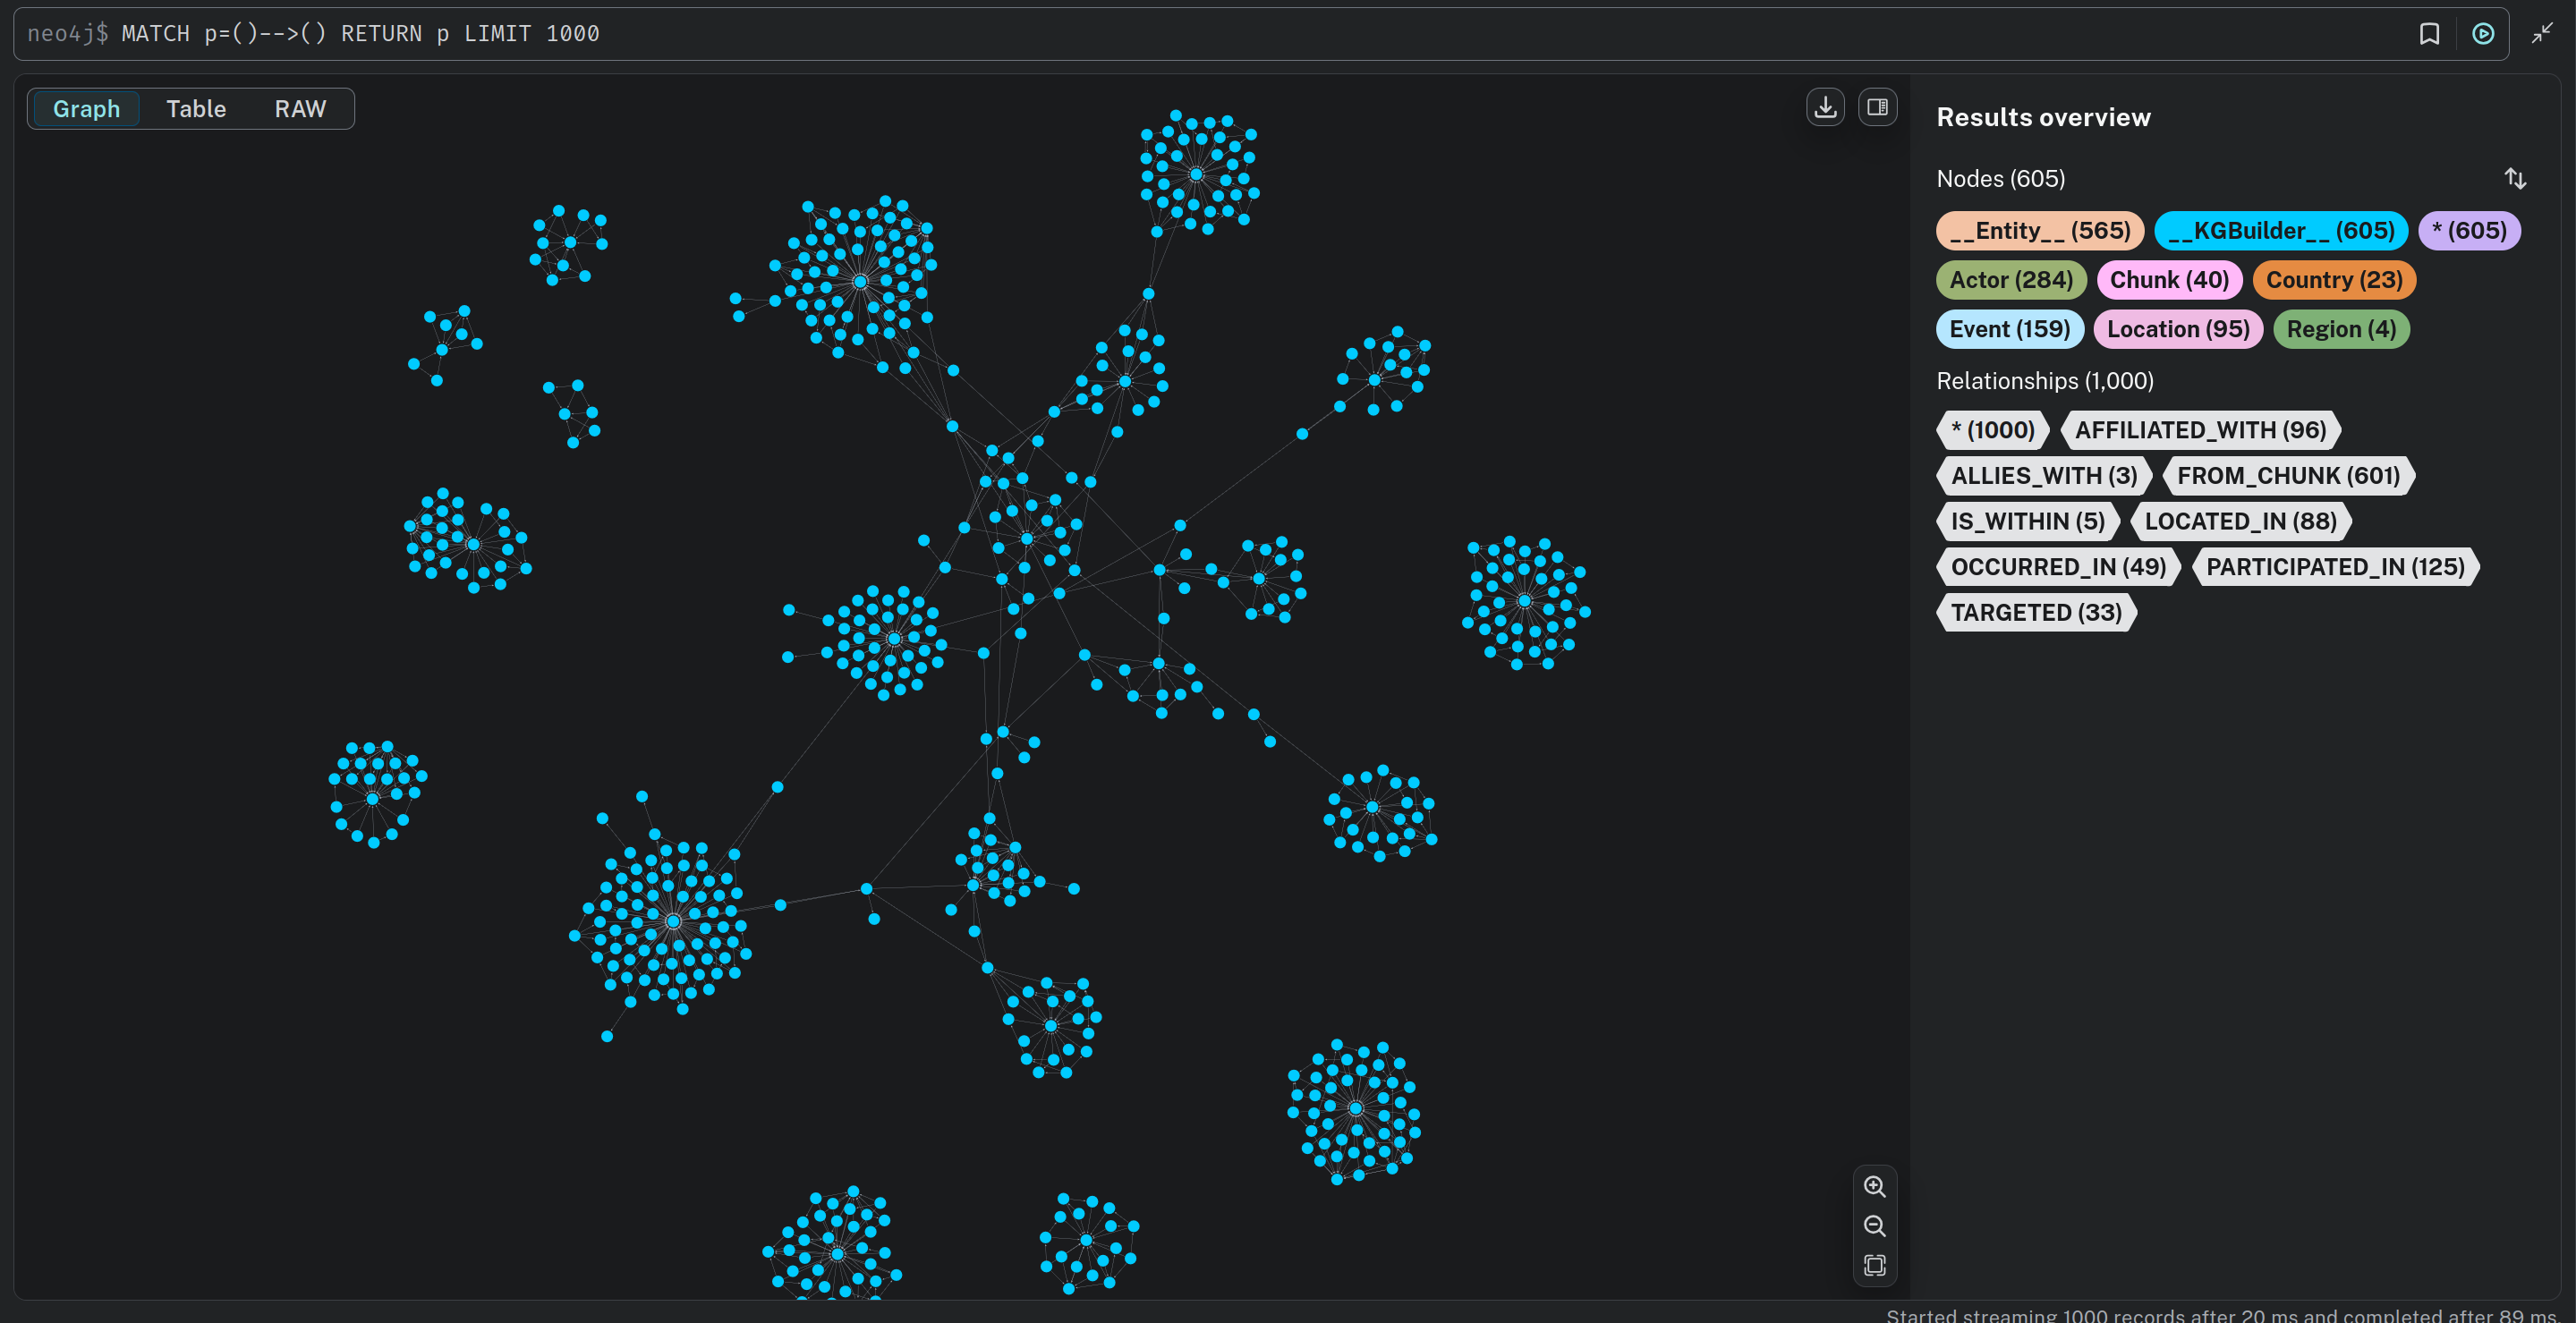

Note that, when the graph is created, chunks are indexed, by default, with a value of 0, and all of them have an embedding assigned (computed through the embedder specified above).

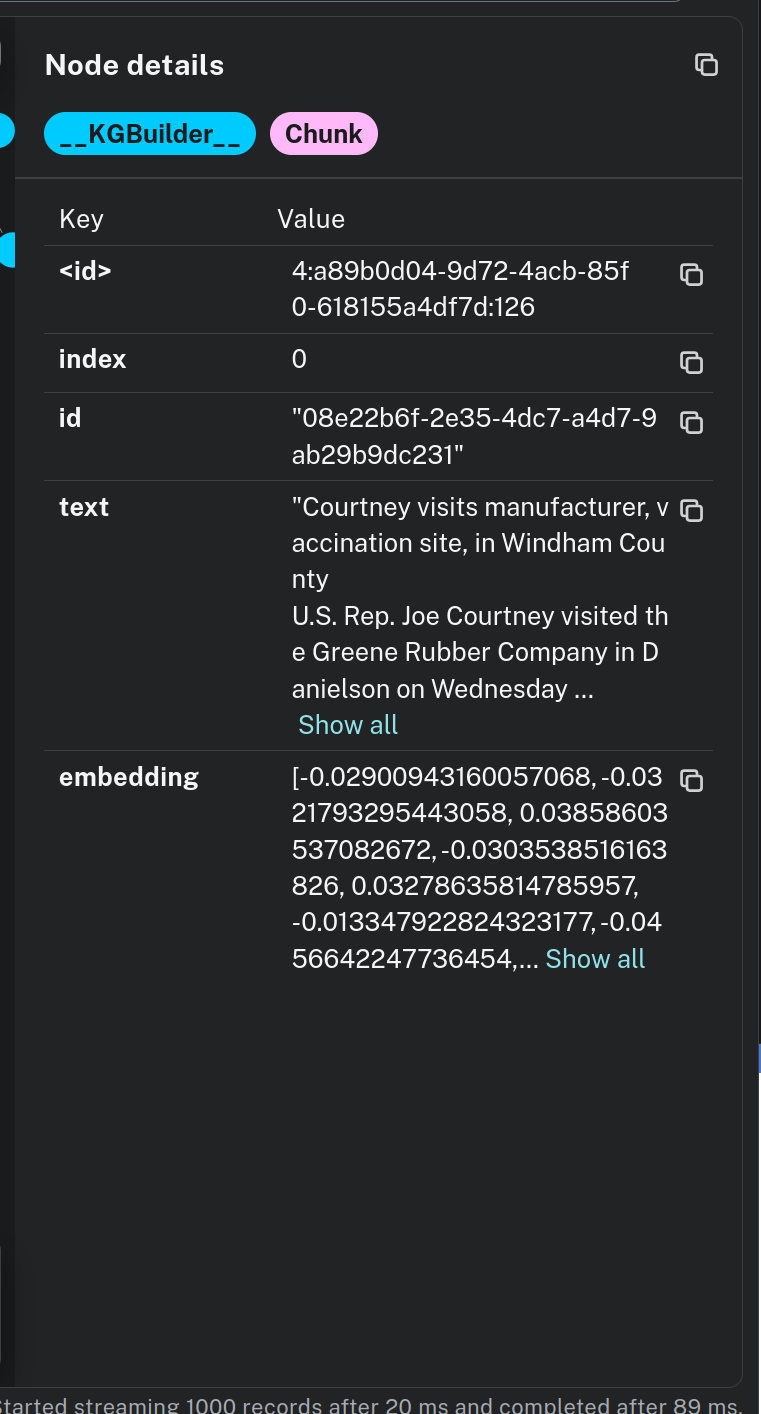

## Knowledge Graph Retrieval

### Vector retrieval (RAG through embeddings)

Alternatives for vector-type retrieval with the `neo4j` library (taken from the blog):

- Vector Retriever: performs similarity searches using vector embeddings
- Vector Cypher Retriever: combines vector search with retrieval queries in Cypher, Neo4j’s Graph Query language, to traverse the graph and incorporate additional nodes and relationships.
- Hybrid Retriever: Combines vector and full-text search.
- Hybrid Cypher Retriever: Combines vector and full-text search with Cypher retrieval queries for additional graph traversal.
- Text2Cypher: converts natural language queries into Cypher queries to run against Neo4j.
- Weaviate & Pinecone Neo4j Retriever: Allows you to search vectors stored in Weaviate or Pinecone and connect them to nodes in Neo4j using external id properties.
- Custom Retriever: allows for tailored retrieval methods based on specific needs.

We will leverage Neo4j's vector search capabilities here. To do this, we need to begin by creating a vector index on the text chunks from the documents, which are stored on `Chunk` nodes in our knowledge graph. This operation is done to speed up vector-related queries.

The number of dimensions has to be adjusted to the particular embedder that has been used (e.g., 384 dimensions for sentence-transformers/all-MiniLM-L6-v2 - [source](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)).

In [ ]:
# from neo4j_graphrag.indexes import drop_index_if_exists

# # Drop a vector index (irreversible)
# drop_index_if_exists(driver, name='text_embeddings')

In [29]:
from neo4j_graphrag.indexes import create_vector_index

create_vector_index(driver, name="text_embeddings", label="Chunk",
                    embedding_property="embedding", dimensions=384, similarity_fn="cosine")

Now that the index is set up, we will start simple with a __VectorRetriever__.  The __VectorRetriever__ just queries `Chunk` nodes via vector search, bringing back the text and some metadata.

In [30]:
from neo4j_graphrag.retrievers import VectorRetriever

vector_retriever = VectorRetriever(
    driver,
    index_name="text_embeddings",
    embedder=embedder,
    return_properties=["text"],
)

Below we visualize the context we get back when submitting a search prompt. 

In [21]:
import json

vector_res = vector_retriever.get_search_results(query_text = "Which have been the most relevant security-related events in the last 10 years in the United States?", 
                                                 top_k=3)
for i in vector_res.records: print("====\n" + json.dumps(i.data(), indent=4))

====
{
    "node": {
        "text": "Must Reads\nMust Reads\nMost Popular\nPopular\nUS\nWorld\nScience\nPolitics\nGreat Finds\nMore\nMore sections\nSuperlatives\nBreaking\nCelebrity\nCrime\nEntertainment\nGreen\nHealth\nLifestyle\nLongform\nMedia\nMoney\nOpinion\nSports\nTech\nTravel\nBrilliant\nHilarious\nIntriguing\nBy date\nToday\nYesterday\nPick-a-date\nDepressing\nRidiculous\nScary\nLog into your Newser account\nLogging in\nJoined Newser on:\nlogout\nSettings\nEmail Subscriptions\nComments\nFind what you're looking for\nMore about Newser:\nAbout Us\nEditorial Policy\nAI Policy\nSweepstakes\nContact Us\nTerms of Use\nPrivacy Policy\nSite Map\nWhat's New\nWant to contribute?\nSuggest a Story\nGet our apps:\niPhone\niPad\nAndroid\nWindows\nInstall our app:\nNewser App\nBreaking News\nTHE GRID\nPOPULAR\nFRONT PAGE\nToday\nYesterday\nFBI Shuts Unit That Investigates\nCongressional Corruption\nMay 15, 2025 7:15 PM CDT\nStudent Busts Teacher Using\nAI, Demands Tuition Refund\nMay 15, 20

The GraphRAG Python Package offers [a wide range of useful retrievers](https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_rag.html#retriever-configuration), each covering different knowledge graph retrieval patterns.

Below we will use the __`VectorCypherRetriever`__, which allows you to run a graph traversal after finding nodes with vector search.  This uses Cypher, Neo4j's graph query language, to define the logic for traversing the graph. 

As a simple starting point, we'll traverse up to 3 hops out from each Chunk, capture the relationships encountered, and include them in the response alongside our text chunks.


In [31]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

vc_retriever = VectorCypherRetriever(
    driver,
    index_name="text_embeddings",
    embedder=embedder,
    retrieval_query="""
//1) Go out 2-3 hops in the entity graph and get relationships
WITH node AS chunk
MATCH (chunk)<-[:FROM_CHUNK]-()-[relList:!FROM_CHUNK]-{1,2}()
UNWIND relList AS rel

//2) collect relationships and text chunks
WITH collect(DISTINCT chunk) AS chunks, 
  collect(DISTINCT rel) AS rels

//3) format and return context
RETURN '=== text ===\n' + apoc.text.join([c in chunks | c.text], '\n---\n') + '\n\n=== kg_rels ===\n' +
  apoc.text.join([r in rels | startNode(r).name + ' - ' + type(r) + '(' + coalesce(r.details, '') + ')' +  ' -> ' + endNode(r).name ], '\n---\n') AS info
"""
)

Below we visualize the context we get back when submitting a search prompt. 

In [17]:
vc_res = vc_retriever.get_search_results(query_text = "Which have been the most relevant security-related events in the last 10 years in the United States?", top_k=3)

# print output
kg_rel_pos = vc_res.records[0]['info'].find('\n\n=== kg_rels ===\n')
print("# Text Chunk Context:")
print(vc_res.records[0]['info'][:kg_rel_pos])
print("# KG Context From Relationships:")
print(vc_res.records[0]['info'][kg_rel_pos:])

# Text Chunk Context:
=== text ===
Must Reads
Must Reads
Most Popular
Popular
US
World
Science
Politics
Great Finds
More
More sections
Superlatives
Breaking
Celebrity
Crime
Entertainment
Green
Health
Lifestyle
Longform
Media
Money
Opinion
Sports
Tech
Travel
Brilliant
Hilarious
Intriguing
By date
Today
Yesterday
Pick-a-date
Depressing
Ridiculous
Scary
Log into your Newser account
Logging in
Joined Newser on:
logout
Settings
Email Subscriptions
Comments
Find what you're looking for
More about Newser:
About Us
Editorial Policy
AI Policy
Sweepstakes
Contact Us
Terms of Use
Privacy Policy
Site Map
What's New
Want to contribute?
Suggest a Story
Get our apps:
iPhone
iPad
Android
Windows
Install our app:
Newser App
Breaking News
THE GRID
POPULAR
FRONT PAGE
Today
Yesterday
FBI Shuts Unit That Investigates
Congressional Corruption
May 15, 2025 7:15 PM CDT
Student Busts Teacher Using
AI, Demands Tuition Refund
May 15, 2025 7:00 PM CDT
Personalized Gene Therapy
Could Help With Rare Conditions
new 

### GraphRAG
 
 You can construct GraphRAG pipelines with the `GraphRAG` class.  At a minimum, you will need to pass the constructor an LLM and a retriever. You can optionally pass a custom prompt template. We will do so here just to provide a bit more guidance for the LLM to stick to information from our data source.
 
Below we create `GraphRAG` objects for both the vector and vector-cypher retrievers. 

In [32]:
from neo4j_graphrag.llm import OpenAILLM as LLM
from neo4j_graphrag.generation import RagTemplate
from neo4j_graphrag.generation.graphrag import GraphRAG

rag_template = RagTemplate(template='''Answer the Question using the following Context. Only respond with information mentioned in the Context. Do not inject any speculative information not mentioned. 

# Question:
{query_text}
 
# Context:
{context}

# Answer:
''', expected_inputs=['query_text', 'context'])

v_rag  = GraphRAG(llm=llm, retriever=vector_retriever, prompt_template=rag_template)
vc_rag = GraphRAG(llm=llm, retriever=vc_retriever, prompt_template=rag_template)

> Why are we including vector-based retrievers when doing GraphRAG here? Isn't the point to precisely avoid using vector embeddings to make the searches?

Answer from Sonnet:

**Understanding Vector-Based Retrievers in GraphRAG**

You're asking an excellent question about the role of vector-based retrievers in GraphRAG. While it might seem counterintuitive, vector embeddings still play an important role in GraphRAG for several reasons:

**Hybrid Retrieval Approach**

GraphRAG doesn't completely eliminate vector embeddings—it enhances them with graph structure. The code shows two different approaches:

1. **Pure Vector Retrieval** (`v_rag`): Uses only semantic similarity through embeddings
2. **Graph-Enhanced Retrieval** (`vc_rag`): Combines vector search with graph traversal

**Why Use Both?**

- **Entry Points**: Vector search provides efficient initial access points into the knowledge graph
- **Comparison**: Setting up both approaches allows for direct comparison of their effectiveness
- **Complementary Strengths**: 
  - Vectors capture semantic similarity
  - Graphs capture explicit relationships and structured information

**The VectorCypherRetriever**

Looking at the `vc_retriever` definition earlier in the notebook, you can see it uses vector search to find relevant chunks, then applies a Cypher query to traverse the graph:

```{python}
vc_retriever = VectorCypherRetriever(
    driver,
    index_name="text_embeddings",
    embedder=embedder,
    retrieval_query="""
    //1) Go out 2-3 hops in the entity graph and get relationships
    WITH node AS chunk
    MATCH (chunk)<-[:FROM_CHUNK]-()-[relList:!FROM_CHUNK]-{1,2}()
    UNWIND relList AS rel
    ...
```

This demonstrates how GraphRAG improves upon pure vector-based RAG by incorporating knowledge graph relationships, rather than completely replacing vector embeddings. It's an augmentation strategy that combines the best of both worlds.

Now we can run GraphRAG and examine the outputs. 

In [33]:
q = "Which have been the most relevant security-related events in the last 10 years in the United States?"
print(f"Vector Response: \n{v_rag.search(q, retriever_config={'top_k':5}).answer}")
print("\n===========================\n")
print(f"Vector + Cypher Response: \n{vc_rag.search(q, retriever_config={'top_k':5}).answer}")

Vector Response: 
I am sorry, but this question cannot be answered from the given context.


Vector + Cypher Response: 
I am sorry, but this document does not contain information about the most relevant security-related events in the last 10 years in the United States.


In [35]:
q = "What has happened in the United States lately?"

v_rag_result = v_rag.search(q, retriever_config={'top_k': 5}, return_context=True)
vc_rag_result = vc_rag.search(q, retriever_config={'top_k': 5}, return_context=True)

print(f"Vector Response: \n{v_rag_result.answer}")
print("\n===========================\n")
print(f"Vector + Cypher Response: \n{vc_rag_result.answer}")

Vector Response: 
Here's what has happened in the United States lately, according to the provided text:

*   **FBI:** The FBI Shuts Unit That Investigates Congressional Corruption (May 15, 2025).
*   **Education:** A student busted a teacher using AI and demanded a tuition refund (May 15, 2025).
*   **Healthcare:** Personalized Gene Therapy Could Help With Rare Conditions (May 15, 2025).
*   **Legal:** Smokey Robinson Is Under Criminal Investigation (May 15, 2025).
*   **Labor:** Kennedy Center Employees File for Vote on Unionizing (May 15, 2025).
*   **Legal:** Florida Executes Man Who Was Eyed in OJ Simpson Case (May 15, 2025).
*   **Legal:** Chris Brown Was Arrested in UK (May 15, 2025).
*   **Cybersecurity:** Coinbase Says Criminals Are Demanding $20M Ransom (May 15, 2025).
*   **Legal:** Suspect Charged in Fires at Starmer Properties (May 15, 2025).
*   **Legal:** Cassive Ventura Cross-Examined in Combs Trial (May 15, 2025).
*   **Labor:** LA Hotel, Airport Workers Win Vote on $30

In [36]:
for i in v_rag_result.retriever_result.items: print(json.dumps(eval(i.content), indent=1))

{
 "text": "Must Reads\nMust Reads\nMost Popular\nPopular\nUS\nWorld\nScience\nPolitics\nGreat Finds\nMore\nMore sections\nSuperlatives\nBreaking\nCelebrity\nCrime\nEntertainment\nGreen\nHealth\nLifestyle\nLongform\nMedia\nMoney\nOpinion\nSports\nTech\nTravel\nBrilliant\nHilarious\nIntriguing\nBy date\nToday\nYesterday\nPick-a-date\nDepressing\nRidiculous\nScary\nLog into your Newser account\nLogging in\nJoined Newser on:\nlogout\nSettings\nEmail Subscriptions\nComments\nFind what you're looking for\nMore about Newser:\nAbout Us\nEditorial Policy\nAI Policy\nSweepstakes\nContact Us\nTerms of Use\nPrivacy Policy\nSite Map\nWhat's New\nWant to contribute?\nSuggest a Story\nGet our apps:\niPhone\niPad\nAndroid\nWindows\nInstall our app:\nNewser App\nBreaking News\nTHE GRID\nPOPULAR\nFRONT PAGE\nToday\nYesterday\nFBI Shuts Unit That Investigates\nCongressional Corruption\nMay 15, 2025 7:15 PM CDT\nStudent Busts Teacher Using\nAI, Demands Tuition Refund\nMay 15, 2025 7:00 PM CDT\nPersonaliz

In [37]:
vc_ls = vc_rag_result.retriever_result.items[0].content.split('\\n---\\n')
for i in vc_ls:
    if "biomarker" in i: print(i)

In [38]:
vc_ls = vc_rag_result.retriever_result.items[0].content.split('\\n---\\n')
for i in vc_ls:
    if "treat" in i: print(i)

In [39]:
q = "Can you summarize the most relevant, recent events in the United States in an engaging report divided by topics?"
print(f"Vector Response: \n{v_rag.search(q, retriever_config={'top_k': 5}).answer}")
print("\n===========================\n")
print(f"Vector + Cypher Response: \n{vc_rag.search(q, retriever_config={'top_k': 5}).answer}")

Vector Response: 
Here's a summary of recent events in the United States, divided by topic:

**Politics:**

*   The FBI shut down a unit that investigates congressional corruption.
*   A judge dealt a blow to Trump's new border strategy.
*   Trump said there would be no peace "until Putin and I get together".
*   A forged document was used to approve a Trump hotel in Europe.
*   SCOTUS case has big implications for Trump agenda.

**Crime:**

*   Smokey Robinson is under criminal investigation.
*   Florida executed a man who was eyed in the OJ Simpson case.
*   Chris Brown was arrested in the UK.
*   Suspect charged in fires at Starmer properties.
*   Former FDNY Fire Chief Gets 3 Years in Corruption Scandal.
*   UnitedHealth is under criminal investigation.

**Business/Economy:**

*   Coinbase said criminals are demanding a $20M ransom.
*   LA Hotel, Airport Workers Win Vote on $30 Minimum Wage.
*   Stocks rose despite warnings on the economy.
*   Walmart is preparing for higher prices